# Exploratory Data Analysis

In [5]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.stats import normaltest
import pickle
import dill
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
indians = pd.read_csv('indians.csv', index_col=False)

In [3]:
with open('indians.pickle', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

In [4]:
X_train.head()

,state,district,rural,usual_residance,religion,social_group_code,house_structure,owner_status,drinking_water_source,is_water_filter,toilet_used,household_have_electricity,lighting_source,cooking_fuel,no_of_dwelling_rooms,kitchen_availability,is_radio,is_television,is_computer,is_telephone,is_washing_machine,is_refrigerator,is_sewing_machine,is_bicycle,is_scooter,is_car,is_tractor,is_water_pump,cart,land_possessed
11138,Uttar Pradesh,43,Rural,Yes,Muslim,Others,Pucca,Owned,Hand pump,No,open defecation,No,Kerosene,Firewood,1.0,Does not have kitchen,No,No,No,Mobile Phone only,No,No,No,No,No,No,No,No,Doesn't have,0.02 to less than 1.00
511653,Bihar,7,Rural,Yes,Muslim,Others,Semi Pucca,Owned,Hand pump,No,open defecation,No,Kerosene,Crop Residue,1.0,Cooking outside house:Has kitchen,No,No,No,Mobile Phone only,No,No,No,Yes,No,No,No,No,Doesn't have,10.00 or more
404399,Madhya Pradesh,13,Rural,Yes,Hindu,ST,Kuccha,Owned,Hand pump,No,open defecation,Yes,Kerosene,Firewood,2.0,Does not have kitchen,No,No,No,No,No,No,No,No,No,No,No,No,Doesn't have,No land
123850,Uttar Pradesh,34,Urban,Yes,Hindu,SC,Pucca,Owned,Tube well or Borehole,No,Flush/Pour flush latrine connected:_To piped s...,Yes,Electricity,LPG/PNG,3.0,Cooking inside the house:Has kitchen,No,No,Without Internet connection,Mobile Phone only,No,No,No,No,No,No,No,No,Doesn't have,No land
303765,Jharkhand,16,Rural,Yes,Christian,ST,Kuccha,Owned,Unprotected dug well,Yes,open defecation,No,Kerosene,Firewood,1.0,Cooking inside the house:Has kitchen,No,No,No,No,No,No,Yes,No,No,No,No,No,Doesn't have,0.02 to less than 1.00


## Distribution of target variable 'lifetime'

**The most important row is 'lifetime', as it is the variable my model will aim to predict. First I need to find out if the column is normally distributed. To get a first impression I'll use a Histogram.**

Text(0, 0.5, 'Number of persons')

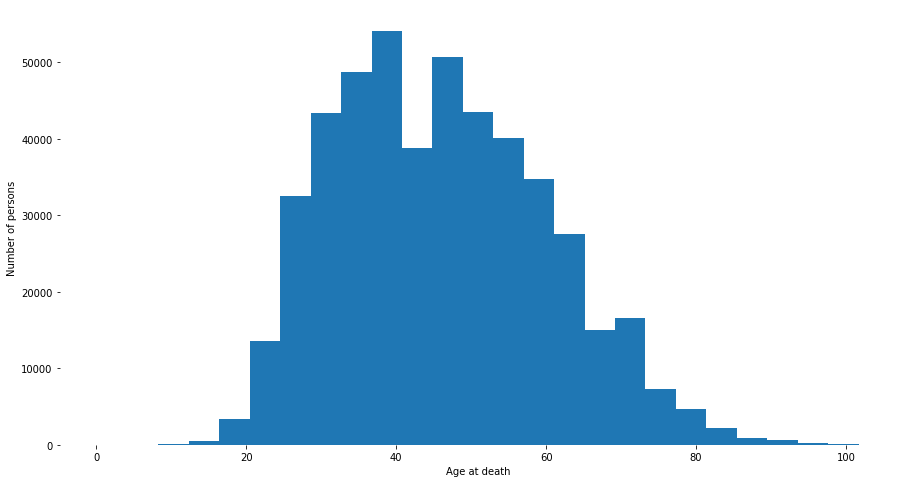

In [8]:
plt.figure(figsize=(15,8))
plt.hist(y_train, bins=25)
sns.despine(bottom=True, left=True)
plt.xlabel('Age at death')
plt.ylabel('Number of persons')




In [9]:
normaltest(y_train)

NormaltestResult(statistic=16732.41574546665, pvalue=0.0)

Text(0, 0.5, 'Number of persons')

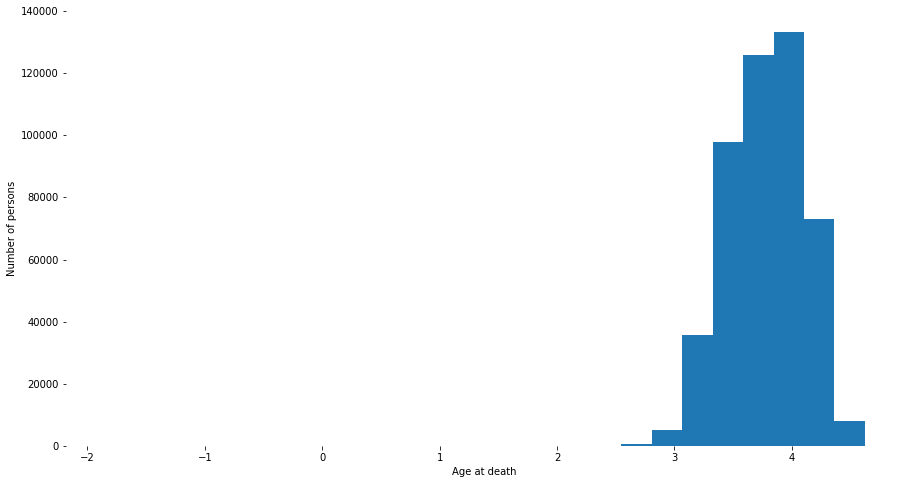

In [10]:
plt.figure(figsize=(15,8))
plt.hist(np.log(y_train), bins=25)
sns.despine(bottom=True, left=True)
plt.xlabel('Age at death')
plt.ylabel('Number of persons')

In [11]:
normaltest(np.log(y_train))

NormaltestResult(statistic=9233.064249608768, pvalue=0.0)

## Permutation test

**Apparently and as expected, the distribution of 'lifetime' in the dataset is not normal, but right-skewed. The natural logarithm of 'lifetime' is not normal as well. Thus I need to do a non-parametric hypothesis test. First I will compare the life expectancies ('lifetime') of the categories of each variable. For each variable I'll do a permutation test of the difference between the group with the highest life expectancy and the group with the lowest life expectancy at an alpha level of 0.05.**

In [2]:
def permutation_test(df, column, alpha_level):
    
    pivtab = df.pivot_table(index=column,values='lifetime', aggfunc=np.mean)
    maxval = pivtab.max()
    minval = pivtab.min()
    maxcat = pivtab.idxmax()
    mincat = pivtab.idxmin()
    diff = maxval - minval
    lenpiv = df.pivot_table(index=column,values='lifetime',aggfunc=len)
    maxlen = int(lenpiv.loc[maxcat].values)
    minlen = int(lenpiv.loc[mincat].values)
    resamples = np.empty(1000)
    np.random.seed(89)
    
    
    
    for i in range(1000):
        sample = df.lifetime.sample(n=maxlen+minlen, replace=False, random_state=i)
        maxsample = sample[:maxlen].mean()
        minsample = sample[maxlen:].mean()
        resamples[i] = abs(maxsample - minsample)
    
    p = sum(resamples>=float(diff.values))/1000
    if p < alpha_level:
        significant = 'Yes'
    else:
        significant = 'No'
    return str(maxcat.values[0]), str(mincat.values[0]), float(diff.values), p, significant
    

In [7]:
with open('permtest.pickle', 'wb') as f:
    dill.dump(permutation_test, f)

In [20]:
indians = pd.concat([X_train, y_train], axis=1)

In [21]:
dicti = {}
for column in indians.columns:
    if indians[column].dtypes == object:
        maxcat, mincat, diff, p, significant = permutation_test(indians, column, 0.05/29)
        dicti[column] = [maxcat, mincat, diff, p, significant]

In [22]:
dicti

{'state': ['Uttarakhand', 'Assam', 4.502496850447294, 0.0, 'Yes'],
 'rural': ['Urban', 'Rural', 1.5018512552308465, 0.0, 'Yes'],
 'religion': ['Jain', 'Others', 9.819228641032595, 0.0, 'Yes'],
 'social_group_code': ['Others', 'ST', 3.4087860539844, 0.0, 'Yes'],
 'house_structure': ['Pucca ', 'Others ', 3.6339857048010558, 0.0, 'Yes'],
 'owner_status': ['Owned', 'Others', 2.964377839363131, 0.0, 'Yes'],
 'drinking_water_source': ['Piped water into dwelling/yard/plot',
  'other sources',
  4.050133341992812,
  0.0,
  'Yes'],
 'is_water_filter': ['Yes', 'No', 0.6684650976556981, 0.0, 'Yes'],
 'toilet_used': ['To septic tank',
  'Open pit /Pit latrine without slab',
  4.391343076813762,
  0.0,
  'Yes'],
 'household_have_electricity': ['Yes', 'No', 2.1284118608827427, 0.0, 'Yes'],
 'lighting_source': ['No lighting', 'Kerosene', 2.540565793836109, 0.0, 'Yes'],
 'cooking_fuel': ['Biogas',
  'Coal/lignite/Charcoal',
  7.2159686187576355,
  0.0,
  'Yes'],
 'kitchen_availability': ['No cooking',

In [23]:
hypotest = pd.DataFrame(dicti, index=['Group with highest life expectancy','Group with lowest life expectancy',\
                             'Difference between both groups','p-value','Stat. sign. at alpha 0.05?']).transpose()

In [24]:
hypotest

,Group with highest life expectancy,Group with lowest life expectancy,Difference between both groups,p-value,Stat. sign. at alpha 0.05?
state,Uttarakhand,Assam,4.5025,0,Yes
rural,Urban,Rural,1.50185,0,Yes
religion,Jain,Others,9.81923,0,Yes
social_group_code,Others,ST,3.40879,0,Yes
house_structure,Pucca,Others,3.63399,0,Yes
owner_status,Owned,Others,2.96438,0,Yes
drinking_water_source,Piped water into dwelling/yard/plot,other sources,4.05013,0,Yes
is_water_filter,Yes,No,0.668465,0,Yes
toilet_used,To septic tank,Open pit /Pit latrine without slab,4.39134,0,Yes
household_have_electricity,Yes,No,2.12841,0,Yes


In [25]:
significant = hypotest[hypotest.iloc[:,-1] == 'Yes']
significant

,Group with highest life expectancy,Group with lowest life expectancy,Difference between both groups,p-value,Stat. sign. at alpha 0.05?
state,Uttarakhand,Assam,4.5025,0,Yes
rural,Urban,Rural,1.50185,0,Yes
religion,Jain,Others,9.81923,0,Yes
social_group_code,Others,ST,3.40879,0,Yes
house_structure,Pucca,Others,3.63399,0,Yes
owner_status,Owned,Others,2.96438,0,Yes
drinking_water_source,Piped water into dwelling/yard/plot,other sources,4.05013,0,Yes
is_water_filter,Yes,No,0.668465,0,Yes
toilet_used,To septic tank,Open pit /Pit latrine without slab,4.39134,0,Yes
household_have_electricity,Yes,No,2.12841,0,Yes


In [55]:
difference_order = significant["Difference between both groups"].sort_values(ascending=False)

**It can be seen that there are many variables that influence life expectancy statistically significantly at an alpha level of 0.05. Among the variables that make the biggest differences are the status of the house, religion, the state a person lives in, whether or not a person has a kitchen,a car,a telephone or a washing machine, or what kind of fuel is used in the household for cooking.**

## Correlation between 'lifetime' and the number of dwelling rooms

**There is only one column of quantitative data (besides 'lifetime'): 'no_of_dwelling_rooms', which describes how many dwelling rooms the household of the individual has. Thus I will see if there is a correlation between this and the lifetime column.**

In [26]:
stats.pearsonr(indians.no_of_dwelling_rooms, indians.lifetime)

(0.1858796449866505, 0.0)

**It turns out that the correlation is weak, but statistically very significant.**

## Figuring out association between categorical feature variables

In [6]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [7]:
with open('cramers_v.pickle','wb') as f:
    dill.dump(cramers_v, f)

In [29]:
cramers_v_matrix = pd.DataFrame()

In [30]:
categorical = indians.drop(['lifetime','no_of_dwelling_rooms'], axis=1)

In [31]:
categorical

,state,district,rural,religion,social_group_code,house_structure,owner_status,drinking_water_source,is_water_filter,toilet_used,household_have_electricity,lighting_source,cooking_fuel,kitchen_availability,is_radio,is_television,is_computer,is_telephone,is_washing_machine,is_refrigerator,is_sewing_machine,is_bicycle,is_scooter,is_car,is_tractor,is_water_pump,cart,land_possessed
10244,Uttar Pradesh,43,Rural,Muslim,Others,Pucca,Owned,Hand pump,No,open defecation,No,Kerosene,Firewood,Does not have kitchen,No,No,No,Mobile Phone only,No,No,No,No,No,No,No,No,Doesn't have,0.02 to less than 1.00
474698,Bihar,7,Rural,Muslim,Others,Semi Pucca,Owned,Hand pump,No,open defecation,No,Kerosene,Crop Residue,Cooking outside house:Has kitchen,No,No,No,Mobile Phone only,No,No,No,Yes,No,No,No,No,Doesn't have,10.00 or more
374210,Madhya Pradesh,13,Rural,Hindu,ST,Kuccha,Owned,Hand pump,No,open defecation,Yes,Kerosene,Firewood,Does not have kitchen,No,No,No,No,No,No,No,No,No,No,No,No,Doesn't have,No land
114849,Uttar Pradesh,34,Urban,Hindu,SC,Pucca,Owned,Tube well or Borehole,No,Flush/Pour flush latrine connected:_To piped s...,Yes,Electricity,LPG/PNG,Cooking inside the house:Has kitchen,No,No,Without Internet connection,Mobile Phone only,No,No,No,No,No,No,No,No,Doesn't have,No land
283119,Jharkhand,16,Rural,Christian,ST,Kuccha,Owned,Unprotected dug well,Yes,open defecation,No,Kerosene,Firewood,Cooking inside the house:Has kitchen,No,No,No,No,No,No,Yes,No,No,No,No,No,Doesn't have,0.02 to less than 1.00
470874,Bihar,12,Rural,Hindu,Others,Pucca,Owned,Hand pump,No,To septic tank,Yes,Kerosene,Cow dung cake,Does not have kitchen,Yes,No,No,Mobile Phone only,No,No,No,No,No,No,No,Yes,Doesn't have,1.00 to less than 4.00
90330,Uttar Pradesh,13,Rural,Hindu,Others,Pucca,Owned,Hand pump,No,open defecation,Yes,Electricity,LPG/PNG,Cooking inside the house:Has kitchen,No,Yes,No,Mobile Phone only,No,Yes,Yes,Yes,Yes,No,No,No,Doesn't have,0.02 to less than 1.00
502210,Bihar,33,Rural,Muslim,Others,Semi Pucca,Owned,Hand pump,No,To pit latrine,No,Kerosene,Cow dung cake,Does not have kitchen,No,No,No,No,No,No,No,No,No,No,No,No,Doesn't have,No land
243440,Odisha,6,Urban,Hindu,ST,Kuccha,Owned,other sources,No,open defecation,Yes,Electricity,Firewood,Does not have kitchen,No,No,No,No,No,No,No,No,No,No,No,No,Doesn't have,0.02 to less than 1.00
439795,Chhattisgarh,13,Rural,Hindu,Others,Pucca,Owned,Hand pump,Yes,open defecation,Yes,Electricity,Firewood,Cooking inside the house:Has kitchen,No,Yes,No,Mobile Phone only,No,No,No,Yes,No,No,No,No,Driven by Animal,1.00 to less than 4.00


In [32]:
for column1 in categorical.columns:
    c_list = []
    for column2 in categorical.columns:
        c_list.append(cramers_v(categorical[column1],categorical[column2]))
    cramers_v_matrix[column1] = c_list

In [33]:
cramers_v_matrix.index = categorical.columns

In [34]:
cramers_v_matrix

,state,district,rural,religion,social_group_code,house_structure,owner_status,drinking_water_source,is_water_filter,toilet_used,household_have_electricity,lighting_source,cooking_fuel,kitchen_availability,is_radio,is_television,is_computer,is_telephone,is_washing_machine,is_refrigerator,is_sewing_machine,is_bicycle,is_scooter,is_car,is_tractor,is_water_pump,cart,land_possessed
state,1.000000,0.338884,0.142622,0.172210,0.253469,0.218410,0.116056,0.242083,0.439204,0.210062,0.352340,0.201437,0.229722,0.255977,0.134250,0.248223,0.046035,0.167201,0.129984,0.179365,0.221766,0.312427,0.125385,0.058368,0.095358,0.139742,0.122825,0.137480
district,0.338884,1.000000,0.178158,0.129196,0.168897,0.155078,0.088274,0.144292,0.241256,0.124384,0.219780,0.115647,0.160598,0.172020,0.125108,0.155592,0.049542,0.099786,0.113925,0.143363,0.103507,0.199010,0.097916,0.055649,0.051637,0.103835,0.090448,0.135649
rural,0.142622,0.178158,0.999992,0.100970,0.095381,0.242655,0.242820,0.401679,0.160367,0.478794,0.252622,0.325580,0.541268,0.212049,0.093541,0.330638,0.150596,0.195195,0.277175,0.355012,0.209186,0.008712,0.209763,0.125673,0.024327,0.042778,0.071583,0.354187
religion,0.172210,0.129196,0.100970,1.000000,0.256342,0.082621,0.024941,0.066201,0.090814,0.089746,0.103197,0.043190,0.056553,0.074098,0.030943,0.097510,0.028873,0.060866,0.098140,0.112942,0.088772,0.049267,0.069706,0.059265,0.058495,0.045203,0.029493,0.073941
social_group_code,0.253469,0.168897,0.095381,0.256342,1.000000,0.211397,0.027874,0.133001,0.088900,0.159904,0.093455,0.054717,0.179870,0.085216,0.080668,0.151427,0.044629,0.159058,0.085734,0.125379,0.135860,0.041874,0.126486,0.065155,0.061150,0.088583,0.033208,0.086614
house_structure,0.218410,0.155078,0.242655,0.082621,0.211397,1.000000,0.065552,0.163679,0.020923,0.236991,0.280741,0.140370,0.216768,0.096699,0.160100,0.346546,0.080698,0.205706,0.184420,0.283064,0.272776,0.046421,0.263427,0.129923,0.091825,0.114021,0.016085,0.047204
owner_status,0.116056,0.088274,0.242820,0.024941,0.027874,0.065552,1.000000,0.123190,0.074771,0.141940,0.078080,0.077677,0.151028,0.062931,0.026839,0.105957,0.039953,0.045477,0.063379,0.097665,0.039321,0.024106,0.049229,0.023598,0.019330,0.040428,0.026208,0.112577
drinking_water_source,0.242083,0.144292,0.401679,0.066201,0.133001,0.163679,0.123190,1.000000,0.327479,0.154122,0.259964,0.162956,0.168006,0.140170,0.126937,0.317734,0.097849,0.141575,0.269249,0.359757,0.244742,0.155391,0.213406,0.138097,0.047319,0.103987,0.026528,0.088424
is_water_filter,0.439204,0.241256,0.160367,0.090814,0.088900,0.020923,0.074771,0.327479,0.999993,0.186076,0.167053,0.219168,0.255629,0.182113,0.053710,0.163359,0.080408,0.112981,0.134190,0.177279,0.100479,0.009235,0.147601,0.099199,0.020856,0.028645,0.050295,0.110903
toilet_used,0.210062,0.124384,0.478794,0.089746,0.159904,0.236991,0.141940,0.154122,0.186076,1.000000,0.328080,0.156606,0.189064,0.215605,0.201637,0.436951,0.140040,0.185752,0.315900,0.433128,0.325882,0.072744,0.338002,0.193242,0.088003,0.087438,0.046736,0.102407


Text(0.5, 1.0, 'Cramers v')

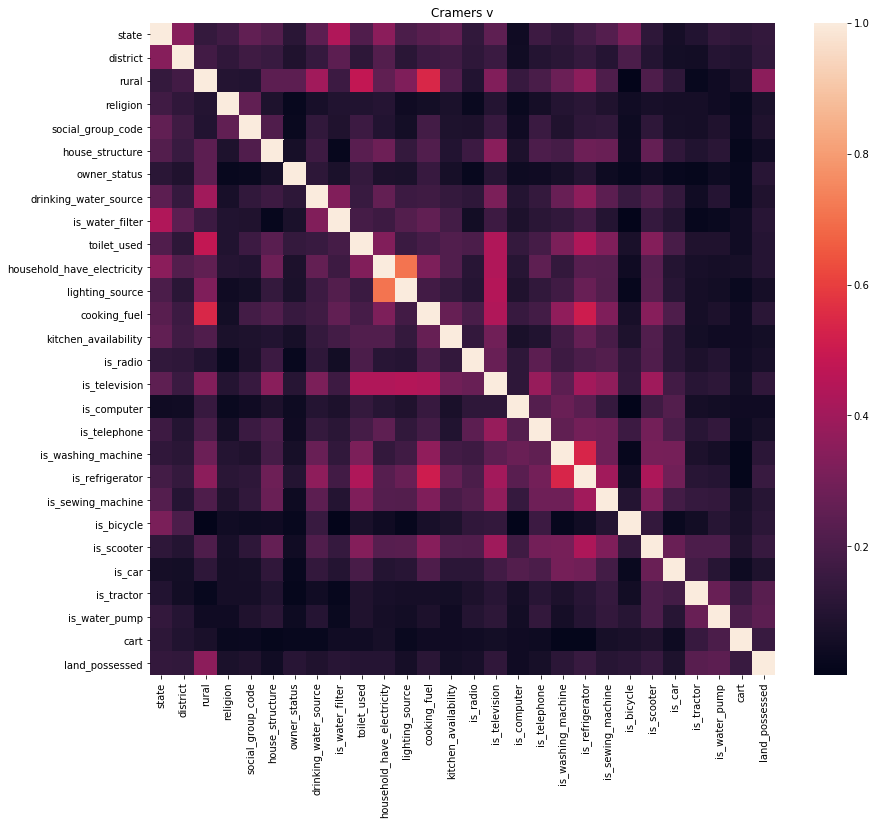

In [35]:
plt.figure(figsize=(14,12))
sns.heatmap(cramers_v_matrix)
plt.title('Cramers v')

**In the heatmap above we can see that many variables are strongly associated with each other. We need to consider this when fitting the linear regression model. But before I need to explore the association between the one numerical variable ('no_of_dwelling_rooms') and each other (categorical) variable.I use spearman's rank-order correlation for this, as it works with numerical and categorical variables and as outliers are not a problem (no_of_dwelling_rooms has strong outliers).**

## Spearman's ranked order correlation between no_of_dwelling_rooms and each categorical feature variable

In [36]:
spearmanr = indians.apply(stats.spearmanr, args=(indians.no_of_dwelling_rooms,))

/home/florian/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [37]:
spearmanr

state                          (0.008083853130394157, 2.1766788314693215e-08)
district                         (-0.002513416914502275, 0.08180836915123148)
rural                                              (0.07803310747014877, 0.0)
religion                      (-0.04975227034621601, 2.2796728127212785e-260)
social_group_code                                 (-0.11870980554548102, 0.0)
house_structure                                    (0.11495455523840481, 0.0)
owner_status                   (-0.01842529197040953, 2.7872559996278256e-37)
drinking_water_source                              (0.06250169283260806, 0.0)
is_water_filter                                    (0.12004169903104175, 0.0)
toilet_used                                        (-0.2691165667961817, 0.0)
household_have_electricity                         (0.21663887942621005, 0.0)
lighting_source                                   (-0.18590018413134293, 0.0)
cooking_fuel                                       (0.1644174918

## Cramer's V > 0.3

**Apparently none of the variables is strongly associated with no_of_dwelling_rooms. I will now search for association pairs with a cramer's v of at least 0.3, as they are signifying a strong association.**

In [9]:
Adef above_cv_threshold(threshold):
    strong_asso = cramers_v_matrix[(cramers_v_matrix>=threshold).sum() > 1]
    strong_asso = strong_asso[strong_asso.index]
    return strong_asso

In [10]:
with open('above_cv_threshold.pickle', 'wb') as f:
    dill.dump(above_cv_threshold, f)

In [39]:
strong_asso = above_cv_threshold(0.3)

In [40]:
strong_asso

,state,district,rural,house_structure,drinking_water_source,is_water_filter,toilet_used,household_have_electricity,lighting_source,cooking_fuel,is_television,is_telephone,is_washing_machine,is_refrigerator,is_sewing_machine,is_bicycle,is_scooter,is_car,land_possessed
state,1.000000,0.338884,0.142622,0.218410,0.242083,0.439204,0.210062,0.352340,0.201437,0.229722,0.248223,0.167201,0.129984,0.179365,0.221766,0.312427,0.125385,0.058368,0.137480
district,0.338884,1.000000,0.178158,0.155078,0.144292,0.241256,0.124384,0.219780,0.115647,0.160598,0.155592,0.099786,0.113925,0.143363,0.103507,0.199010,0.097916,0.055649,0.135649
rural,0.142622,0.178158,0.999992,0.242655,0.401679,0.160367,0.478794,0.252622,0.325580,0.541268,0.330638,0.195195,0.277175,0.355012,0.209186,0.008712,0.209763,0.125673,0.354187
house_structure,0.218410,0.155078,0.242655,1.000000,0.163679,0.020923,0.236991,0.280741,0.140370,0.216768,0.346546,0.205706,0.184420,0.283064,0.272776,0.046421,0.263427,0.129923,0.047204
drinking_water_source,0.242083,0.144292,0.401679,0.163679,1.000000,0.327479,0.154122,0.259964,0.162956,0.168006,0.317734,0.141575,0.269249,0.359757,0.244742,0.155391,0.213406,0.138097,0.088424
is_water_filter,0.439204,0.241256,0.160367,0.020923,0.327479,0.999993,0.186076,0.167053,0.219168,0.255629,0.163359,0.112981,0.134190,0.177279,0.100479,0.009235,0.147601,0.099199,0.110903
toilet_used,0.210062,0.124384,0.478794,0.236991,0.154122,0.186076,1.000000,0.328080,0.156606,0.189064,0.436951,0.185752,0.315900,0.433128,0.325882,0.072744,0.338002,0.193242,0.102407
household_have_electricity,0.352340,0.219780,0.252622,0.280741,0.259964,0.167053,0.328080,0.999996,0.711947,0.319297,0.438542,0.248881,0.139957,0.226728,0.223807,0.043858,0.229225,0.100255,0.103707
lighting_source,0.201437,0.115647,0.325580,0.140370,0.162956,0.219168,0.156606,0.711947,1.000000,0.175520,0.446699,0.134268,0.173356,0.271835,0.221236,0.022424,0.232018,0.112066,0.059559
cooking_fuel,0.229722,0.160598,0.541268,0.216768,0.168006,0.255629,0.189064,0.319297,0.175520,1.000000,0.437883,0.179859,0.364296,0.508821,0.326171,0.068620,0.342373,0.206791,0.113150


In [41]:
strong_asso.loc['is_car']['state']

0.058367663448475535

In [76]:
association_pairs = []
association_pairs_dict = {}
for colname in strong_asso.columns:
    print(colname + ':\n')
    association_pairs_dict[colname] = []
    for rowname in strong_asso.index:
        if colname != rowname:
            if strong_asso.loc[rowname][colname] >= 0.3:
                print(colname + ' is associated with ' + rowname + '. Association: ' + str(strong_asso.loc[rowname][colname]))
                association_pairs.append((colname,rowname))
                association_pairs_dict[colname].append(rowname)
    print('\n\n')

state:

state is associated with district. Association: 0.33888378253239887
state is associated with is_water_filter. Association: 0.4392037045207218
state is associated with household_have_electricity. Association: 0.3523397804251211
state is associated with is_bicycle. Association: 0.31242670400264727



district:

district is associated with state. Association: 0.33888378253239887



rural:

rural is associated with drinking_water_source. Association: 0.4016794059262849
rural is associated with toilet_used. Association: 0.47879434220024836
rural is associated with lighting_source. Association: 0.325580260301738
rural is associated with cooking_fuel. Association: 0.5412677905007457
rural is associated with is_television. Association: 0.33063804738668556
rural is associated with is_refrigerator. Association: 0.3550118906852497
rural is associated with land_possessed. Association: 0.3541870331334157



house_structure:

house_structure is associated with is_television. Association: 0.3

In [78]:
association_pairs_dict

{'state': ['district',
  'is_water_filter',
  'household_have_electricity',
  'is_bicycle'],
 'district': ['state'],
 'rural': ['drinking_water_source',
  'toilet_used',
  'lighting_source',
  'cooking_fuel',
  'is_television',
  'is_refrigerator',
  'land_possessed'],
 'house_structure': ['is_television'],
 'drinking_water_source': ['rural',
  'is_water_filter',
  'is_television',
  'is_refrigerator'],
 'is_water_filter': ['state', 'drinking_water_source'],
 'toilet_used': ['rural',
  'household_have_electricity',
  'is_television',
  'is_washing_machine',
  'is_refrigerator',
  'is_sewing_machine',
  'is_scooter'],
 'household_have_electricity': ['state',
  'toilet_used',
  'lighting_source',
  'cooking_fuel',
  'is_television'],
 'lighting_source': ['rural', 'household_have_electricity', 'is_television'],
 'cooking_fuel': ['rural',
  'household_have_electricity',
  'is_television',
  'is_washing_machine',
  'is_refrigerator',
  'is_sewing_machine',
  'is_scooter'],
 'is_television':

In [67]:
graph = nx.Graph()

In [68]:
graph.add_nodes_from(strong_asso.columns)

In [69]:
graph.nodes

NodeView(('state', 'district', 'rural', 'house_structure', 'drinking_water_source', 'is_water_filter', 'toilet_used', 'household_have_electricity', 'lighting_source', 'cooking_fuel', 'is_television', 'is_telephone', 'is_washing_machine', 'is_refrigerator', 'is_sewing_machine', 'is_bicycle', 'is_scooter', 'is_car', 'land_possessed'))

In [70]:
for association_pair in association_pairs:
    graph.add_edge(association_pair[0],association_pair[1])

In [71]:
graph.edges

EdgeView([('state', 'district'), ('state', 'is_water_filter'), ('state', 'household_have_electricity'), ('state', 'is_bicycle'), ('rural', 'drinking_water_source'), ('rural', 'toilet_used'), ('rural', 'lighting_source'), ('rural', 'cooking_fuel'), ('rural', 'is_television'), ('rural', 'is_refrigerator'), ('rural', 'land_possessed'), ('house_structure', 'is_television'), ('drinking_water_source', 'is_water_filter'), ('drinking_water_source', 'is_television'), ('drinking_water_source', 'is_refrigerator'), ('toilet_used', 'household_have_electricity'), ('toilet_used', 'is_television'), ('toilet_used', 'is_washing_machine'), ('toilet_used', 'is_refrigerator'), ('toilet_used', 'is_sewing_machine'), ('toilet_used', 'is_scooter'), ('household_have_electricity', 'lighting_source'), ('household_have_electricity', 'cooking_fuel'), ('household_have_electricity', 'is_television'), ('lighting_source', 'is_television'), ('cooking_fuel', 'is_television'), ('cooking_fuel', 'is_washing_machine'), ('coo

/home/florian/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


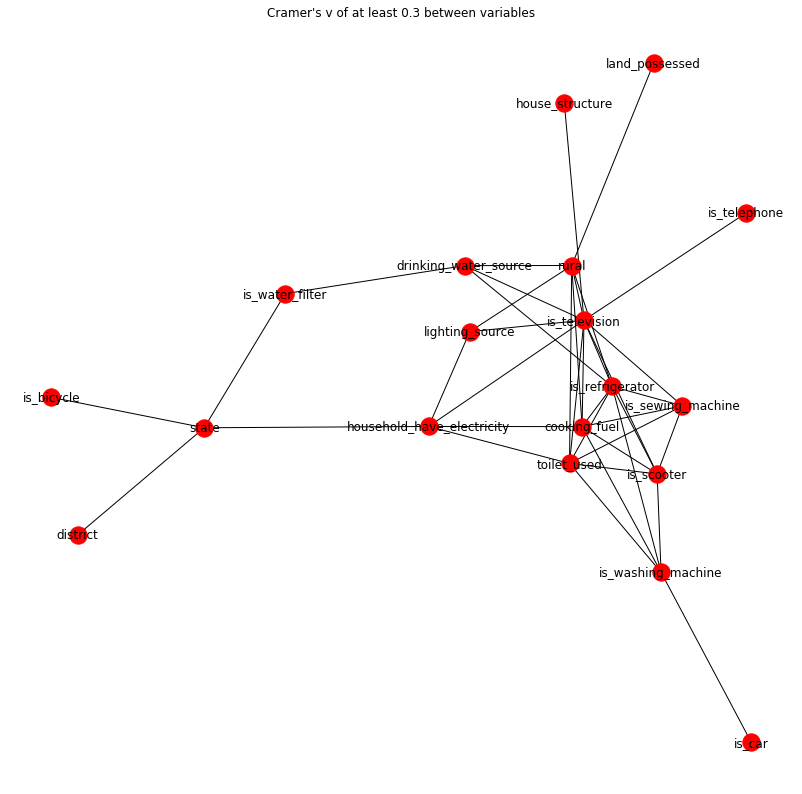

In [72]:
plt.figure(figsize=(14,14))
nx.draw_networkx(graph, with_label=True)
sns.despine(bottom=True, left=True)
plt.xticks([])
plt.yticks([])
plt.title("Cramer's v of at least 0.3 between variables")
plt.savefig('cramers_v.png')

In [79]:
with open('info.pickle','wb') as f:
    pickle.dump([difference_order,association_pairs_dict],f)